# **Importing dataset**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d zaraks/pascal-voc-2007

 99% 1.64G/1.65G [00:17<00:00, 65.2MB/s]
100% 1.65G/1.65G [00:17<00:00, 99.6MB/s]


In [ ]:
import zipfile

file_path = '/content/pascal-voc-2007.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/pascal-voc-2007')

In [ ]:
%mkdir pascal_dataset
%cd pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/
%mv `ls | head -100` ../../../../../pascal_dataset/
%cd ../../../../../

/content/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages
/content


# **Setup yolo**

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 4.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2 as cv
import math
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
model = YOLO("yolo-Weights/yolov8n.pt")

# object classes
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]


100%|██████████| 6.23M/6.23M [00:00<00:00, 79.7MB/s]



WARNING ⚠️ NMS time limit 0.550s exceeded
0: 544x640 8 cars, 1 traffic light, 130.3ms
Speed: 12.9ms preprocess, 130.3ms inference, 819.9ms postprocess per image at shape (1, 3, 544, 640)
9


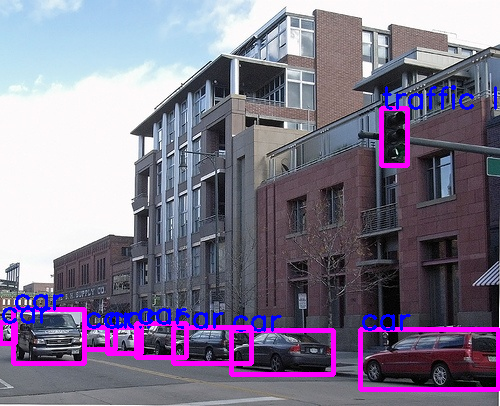

In [ ]:
img = cv.imread("/content/pascal_dataset/000004.jpg")
results = model(img)

for r in results:
    boxes = r.boxes
    print(len(boxes))

    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)

        cls = int(box.cls[0])

        # object details
        org = [x1, y1]
        font = cv.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2

        cv.putText(img, classNames[cls], org, font, fontScale, color, thickness)

cv2_imshow(img)

# **Setup faster rcnn**

In [ ]:
import torch
import torchvision
from torchvision import transforms as T

model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

model2.eval()

ig = cv.imread("/content/pascal_dataset/000004.jpg")

transform = T.ToTensor()
img2 = transform(ig)

with torch.no_grad():
    pred = model2([img2])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 88.4MB/s]


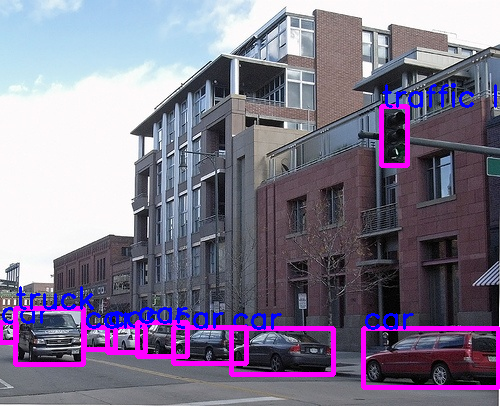

In [ ]:
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]

num = torch.argwhere(scores > 0.9).shape[0]

igg = cv.imread("/content/pascal_dataset/000004.jpg")

for i in range(num):
    x1, y1, x2, y2 = bboxes[i].numpy().astype("int")
    class_name = classNames[labels.numpy()[i] - 1]
    igg = cv.rectangle(igg, (x1, y1), (x2, y2), (255, 0, 255), 3)

    org = [x1, y1]
    font = cv.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    color = (255, 0, 0)
    thickness = 2

    cv.putText(igg, class_name, org, font, fontScale, color, thickness)

cv2_imshow(igg)